## 06 模型比较与分析

In [2]:
import os
import json
import pandas as pd


def load_training_results(save_path="results/model_training_results.json"):  
    """
    加载训练结果记录
    
    Args:
        save_path: JSON文件路径
    
    Returns:
        list: 训练结果记录列表
    """
    if not os.path.exists(save_path):
        print(f"文件 {save_path} 不存在")
        return []
    
    try:
        with open(save_path, 'r', encoding='utf-8') as f:
            records = json.load(f)
        
        if not isinstance(records, list):
            records = [records] if records else []
            
        print(f"✓ 成功加载 {len(records)} 条训练记录")
        return records
        
    except json.JSONDecodeError as e:
        print(f"错误: JSON文件格式错误: {e}")
        return []
    except Exception as e:
        print(f"错误: 加载文件时出现问题: {e}")
        return []


def analyze_training_records(save_path="results/model_training_results.json", show_details=True):  #@save
    """
    分析训练记录，提供模型性能对比
    
    Args:
        save_path: JSON文件路径
        show_details: 是否显示详细信息
    
    Returns:
        pandas.DataFrame: 分析结果表格
    """
    records = load_training_results(save_path)
    
    if not records:
        print("没有找到训练记录")
        return None
    
    # 提取关键信息
    analysis_data = []
    for i, record in enumerate(records):
        data = {
            'Index': i,
            'Model_Class': record.get('model_class', 'Unknown'),
            'Model_Name': record.get('model_name', 'Unknown'),
            'Epochs': record.get('actual_epochs', 0),
            'Device': record.get('device', 'Unknown'),
            'Pretrained_Embeddings': record.get('use_pretrained_embeddings', False),
            'Test_Accuracy': record.get('test_results', {}).get('accuracy', 0),
            'Test_F1': record.get('test_results', {}).get('f1', 0),
            'Test_Precision': record.get('test_results', {}).get('precision', 0),
            'Test_Recall': record.get('test_results', {}).get('recall', 0),
            'Total_Parameters': record.get('model_config', {}).get('total_parameters', 0),
            'Timestamp': record.get('timestamp', 'Unknown')
        }
        analysis_data.append(data)
    
    # 创建DataFrame
    df = pd.DataFrame(analysis_data)
    
    if show_details:
        print("\n" + "="*100)
        print("训练记录分析")
        print("="*100)
        
        # 显示总体统计
        print(f"总训练记录数: {len(records)}")
        print(f"涉及模型类别: {df['Model_Class'].nunique()}")
        print(f"最佳F1分数: {df['Test_F1'].max():.4f} ({df.loc[df['Test_F1'].idxmax(), 'Model_Name']})")
        print(f"最佳准确率: {df['Test_Accuracy'].max():.4f} ({df.loc[df['Test_Accuracy'].idxmax(), 'Model_Name']})")
        
        # 显示详细表格
        print("\n详细训练记录:")
        display_columns = ['Index', 'Model_Name', 'Epochs', 'Test_Accuracy', 'Test_F1', 'Timestamp']
        print(df[display_columns].round(4).to_string(index=False))
    
    return df

In [3]:
file_path = "results/model_training_results_test.json"

results = load_training_results(file_path)


✓ 成功加载 10 条训练记录


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# 分析训练结果
df = analyze_training_records(file_path, show_details=True)

✓ 成功加载 10 条训练记录

训练记录分析
总训练记录数: 10
涉及模型类别: 6
最佳F1分数: 0.8243 (MacBERT)
最佳准确率: 0.8266 (MacBERT)

详细训练记录:
 Index                             Model_Name  Epochs  Test_Accuracy  Test_F1           Timestamp
     0                            TF-IDF + LR      10         0.7364   0.7335 2025-11-17 18:43:46
     1                                    MLP       6         0.7436   0.7398 2025-11-17 18:48:17
     2                                    CNN       6         0.7278   0.7199 2025-11-17 18:53:16
     3                                   LSTM       5         0.7604   0.7572 2025-11-17 18:59:34
     4                            Transformer      10         0.6997   0.6944 2025-11-17 19:12:35
     5         MLP with Pretrained Embeddings       5         0.7441   0.7397 2025-11-17 19:20:19
     6         CNN with Pretrained Embeddings       7         0.7492   0.7453 2025-11-17 19:25:56
     7        LSTM with Pretrained Embeddings       5         0.7618   0.7627 2025-11-17 19:32:12
     8 Transfor

# 1. 所有模型测试结果综合比较

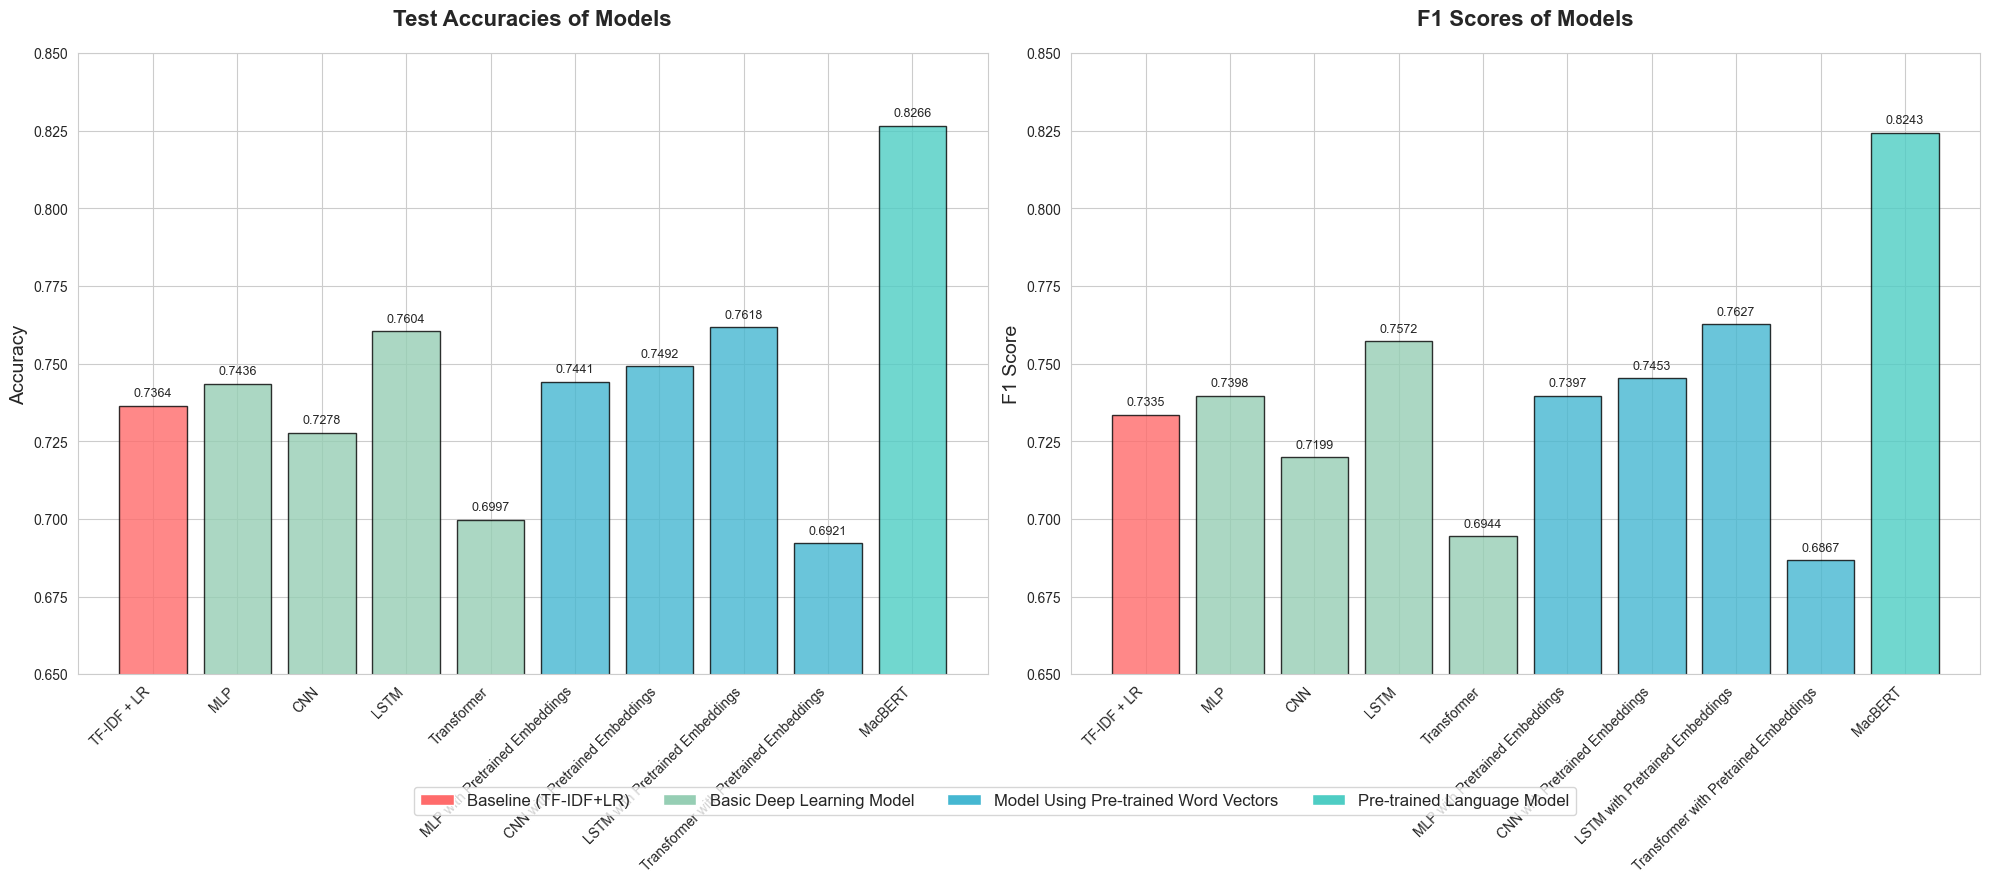

In [5]:
# 1.1 所有模型测试性能对比
def plot_all_models_comparison(df):
    """绘制所有模型的测试性能对比图"""
    
    # 创建子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # 准备数据
    model_names = df['Model_Name'].values
    accuracies = df['Test_Accuracy'].values
    f1_scores = df['Test_F1'].values
    
    # 为不同类型的模型设置不同颜色
    colors = []
    for name in model_names:
        if 'TF-IDF' in name:
            colors.append('#FF6B6B')  # 红色 - 基线模型
        elif 'MacBERT' in name:
            colors.append('#4ECDC4')  # 青色 - 预训练语言模型
        elif 'Pretrained' in name:
            colors.append('#45B7D1')  # 蓝色 - 使用预训练词向量
        else:
            colors.append('#96CEB4')  # 绿色 - 基础深度学习模型
    
    # 绘制准确率对比
    bars1 = ax1.bar(range(len(model_names)), accuracies, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Test Accuracies of Models', fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Accuracy', fontsize=14)
    ax1.set_ylim([0.65, 0.85])
    ax1.set_xticks(range(len(model_names)))
    ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
    
    # 在柱子上添加数值标签
    for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=9)
    
    # 绘制F1分数对比
    bars2 = ax2.bar(range(len(model_names)), f1_scores, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('F1 Scores of Models', fontsize=16, fontweight='bold', pad=20)
    ax2.set_ylabel('F1 Score', fontsize=14)
    ax2.set_ylim([0.65, 0.85])
    ax2.set_xticks(range(len(model_names)))
    ax2.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
    
    # 在柱子上添加数值标签
    for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{f1:.4f}', ha='center', va='bottom', fontsize=9)
    
    # 添加图例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF6B6B', label='Baseline (TF-IDF+LR)'),
        Patch(facecolor='#96CEB4', label='Basic Deep Learning Model'),
        Patch(facecolor='#45B7D1', label='Model Using Pre-trained Word Vectors'),
        Patch(facecolor='#4ECDC4', label='Pre-trained Language Model')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    
    return fig

# 绘制对比图
fig1 = plot_all_models_comparison(df);

## 分析结论1：整体模型性能对比

从上图可以看出：

1. **最优模型**：MacBERT表现最佳，准确率达到82.66%，F1分数达到82.43%，显著优于其他所有模型。

2. **性能层次**：
   - **第一梯队**：MacBERT（预训练语言模型）
   - **第二梯队**：LSTM系列模型（76.04%-76.18%）
   - **第三梯队**：MLP和CNN系列模型（72.78%-74.92%）
   - **第四梯队**：Transformer系列模型（69.21%-69.97%）

3. **预训练词向量的影响**：
   - 对LSTM和CNN模型有轻微提升
   - 对MLP模型基本无影响
   - 对Transformer模型反而有负面影响

4. **基线模型表现**：TF-IDF+LR作为基线模型表现中规中矩，准确率73.64%，为深度学习模型提供了合理的基准。

# 2. 未使用预训练词向量的基准模型比较

基准模型数量: 5

基准模型测试性能:
    Model_Name  Test_Accuracy  Test_F1
0  TF-IDF + LR         0.7364   0.7335
1          MLP         0.7436   0.7398
2          CNN         0.7278   0.7199
3         LSTM         0.7604   0.7572
4  Transformer         0.6997   0.6944


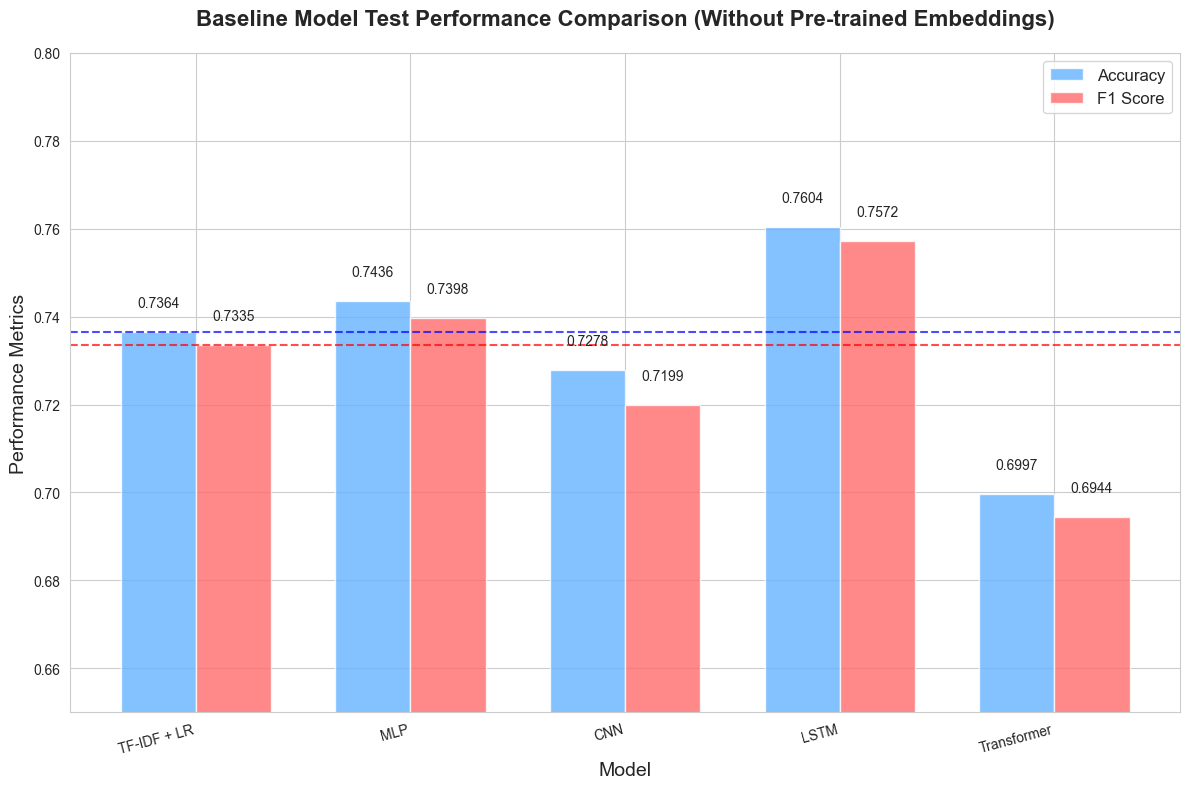

In [15]:
# 2.1 提取基准模型数据（未使用预训练词向量）
def extract_baseline_models(results):
    """提取基准模型数据"""
    baseline_models = []
    for record in results:
        if not record.get('use_pretrained_embeddings', False) and record['model_class'] != 'BERT':
            baseline_models.append(record)
    return baseline_models

baseline_results = extract_baseline_models(results)
print(f"基准模型数量: {len(baseline_results)}")

# 创建基准模型的DataFrame
baseline_data = []
for record in baseline_results:
    data = {
        'Model_Name': record.get('model_name', 'Unknown'),
        'Model_Class': record.get('model_class', 'Unknown'),
        'Test_Accuracy': record.get('test_results', {}).get('accuracy', 0),
        'Test_F1': record.get('test_results', {}).get('f1', 0),
        'Test_Precision': record.get('test_results', {}).get('precision', 0),
        'Test_Recall': record.get('test_results', {}).get('recall', 0),
        'Training_History': record.get('training_history', {})
    }
    baseline_data.append(data)

baseline_df = pd.DataFrame(baseline_data)
print("\n基准模型测试性能:")
print(baseline_df[['Model_Name', 'Test_Accuracy', 'Test_F1']].round(4))

# 2.2 基准模型测试性能比较
def plot_baseline_performance(baseline_df):
    """绘制基准模型测试性能对比"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # 数据准备
    models = baseline_df['Model_Name'].values
    accuracies = baseline_df['Test_Accuracy'].values
    f1_scores = baseline_df['Test_F1'].values
    
    x = np.arange(len(models))
    width = 0.35
    
    # 绘制柱状图
    bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#66B2FF', alpha=0.8)
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='#FF6B6B', alpha=0.8)
    
    # 添加数值标签
    for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
        ax.text(i - width/2, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)
        ax.text(i + width/2, f1 + 0.005, f'{f1:.4f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel('Model', fontsize=14)
    ax.set_ylabel('Performance Metrics', fontsize=14)
    ax.set_title('Baseline Model Test Performance Comparison (Without Pre-trained Embeddings)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15, ha='right')
    ax.legend(fontsize=12)
    ax.set_ylim(0.65, 0.8)
    
    # 添加基线参考线（TF-IDF+LR的性能）
    tfidf_acc = baseline_df[baseline_df['Model_Name'] == 'TF-IDF + LR']['Test_Accuracy'].iloc[0]
    tfidf_f1 = baseline_df[baseline_df['Model_Name'] == 'TF-IDF + LR']['Test_F1'].iloc[0]
    ax.axhline(y=tfidf_acc, color='blue', linestyle='--', alpha=0.7, label=f'TF-IDF+LR Accuracy Baseline: {tfidf_acc:.4f}')
    ax.axhline(y=tfidf_f1, color='red', linestyle='--', alpha=0.7, label=f'TF-IDF+LR F1 Baseline: {tfidf_f1:.4f}')
    
    plt.tight_layout()
    plt.show()
    return fig

fig2 = plot_baseline_performance(baseline_df)

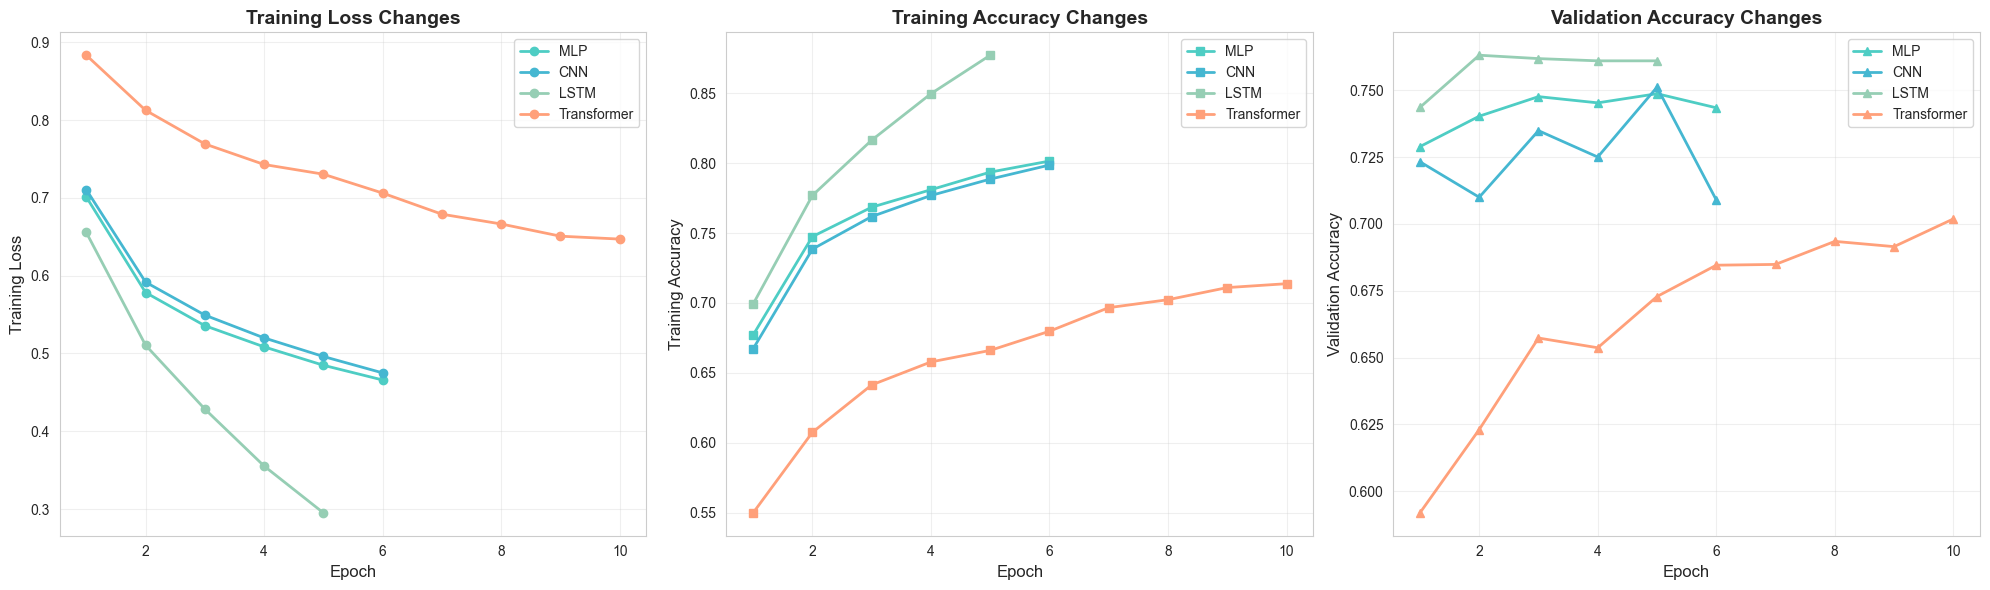

In [7]:
# 2.3 基准模型训练过程比较
def plot_training_process(baseline_results):
    """绘制基准模型训练过程对比"""
    
    # 创建3个子图：训练损失、训练准确率、验证准确率
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFA07A']
    
    for i, record in enumerate(baseline_results):
        model_name = record['model_name']
        history = record['training_history']
        
        # 跳过TF-IDF+LR（它没有训练历史）
        if 'TF-IDF' in model_name:
            continue
            
        epochs = list(range(1, len(history['train_losses']) + 1))
        
        # 训练损失
        ax1.plot(epochs, history['train_losses'], marker='o', 
                label=model_name, color=colors[i], linewidth=2, markersize=6)
        
        # 训练准确率
        ax2.plot(epochs, history['train_accuracies'], marker='s', 
                label=model_name, color=colors[i], linewidth=2, markersize=6)
        
        # 验证准确率
        ax3.plot(epochs, history['val_accuracies'], marker='^', 
                label=model_name, color=colors[i], linewidth=2, markersize=6)
    
    # 设置子图1：训练损失
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title('Training Loss Changes', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 设置子图2：训练准确率
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Training Accuracy', fontsize=12)
    ax2.set_title('Training Accuracy Changes', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 设置子图3：验证准确率
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Validation Accuracy', fontsize=12)
    ax3.set_title('Validation Accuracy Changes', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return fig

fig3 = plot_training_process(baseline_results)

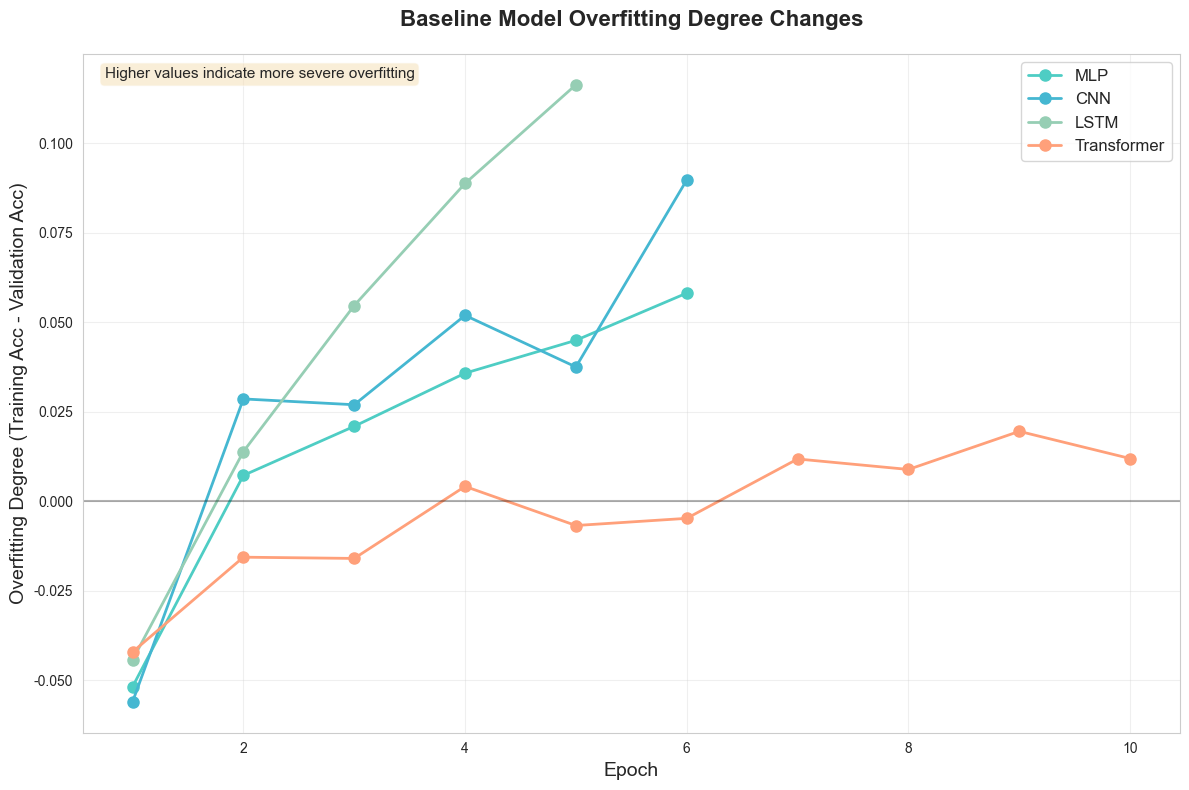

In [8]:
# 2.4 基准模型过拟合程度比较
def plot_overfitting_analysis(baseline_results):
    """绘制基准模型过拟合程度分析"""
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFA07A']
    
    for i, record in enumerate(baseline_results):
        model_name = record['model_name']
        history = record['training_history']
        
        # 跳过TF-IDF+LR
        if 'TF-IDF' in model_name:
            continue
            
        # 计算过拟合程度（训练准确率 - 验证准确率）
        train_acc = np.array(history['train_accuracies'])
        val_acc = np.array(history['val_accuracies'])
        overfitting = train_acc - val_acc
        
        epochs = list(range(1, len(overfitting) + 1))
        
        ax.plot(epochs, overfitting, marker='o', label=model_name, 
               color=colors[i], linewidth=2, markersize=8)
    
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Overfitting Degree (Training Acc - Validation Acc)', fontsize=14)
    ax.set_title('Baseline Model Overfitting Degree Changes', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 添加说明文字
    ax.text(0.02, 0.98, 'Higher values indicate more severe overfitting', transform=ax.transAxes, 
           fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    return fig

fig4 = plot_overfitting_analysis(baseline_results)

## 分析结论2：基准模型（未使用预训练词向量）比较

### 2.1 测试性能比较（以TF-IDF+LR为基线）:
- **LSTM**：表现最佳，准确率76.04%，F1分数75.72%，相比基线提升2.4%
- **MLP**：准确率74.36%，F1分数73.98%，相比基线提升0.6%  
- **TF-IDF+LR**：基线性能，准确率73.64%，F1分数73.35%
- **CNN**：准确率72.78%，F1分数71.99%，相比基线下降0.9%
- **Transformer**：表现最差，准确率69.97%，F1分数69.44%，相比基线下降3.6%

### 2.2 训练过程分析:
- **收敛速度**：LSTM收敛最快（5个epoch），MLP和CNN次之（6个epoch），Transformer最慢（10个epoch）
- **训练稳定性**：LSTM训练最稳定，损失下降平滑；CNN和MLP波动较小；Transformer波动最大
- **验证性能**：LSTM验证准确率最高且稳定；MLP表现稳定；CNN有轻微波动；Transformer起步低但持续改善

### 2.3 过拟合分析:
- **LSTM**：过拟合最严重，随训练进行过拟合程度持续增加，最终达到11%
- **CNN**：中等过拟合，在训练后期过拟合程度约为9%
- **MLP**：轻微过拟合，过拟合程度约为6%
- **Transformer**：过拟合程度最低，仅约1-2%，说明模型容量与数据匹配较好

**关键发现**：LSTM虽然测试性能最好，但存在严重过拟合问题；Transformer虽然过拟合最轻，但整体性能较差，可能需要更多数据或调参。

# 3. 使用预训练词向量的模型比较

使用预训练词向量的模型数量: 4

使用预训练词向量模型测试性能:
                               Model_Name  Test_Accuracy  Test_F1
0          MLP with Pretrained Embeddings         0.7441   0.7397
1          CNN with Pretrained Embeddings         0.7492   0.7453
2         LSTM with Pretrained Embeddings         0.7618   0.7627
3  Transformer with Pretrained Embeddings         0.6921   0.6867


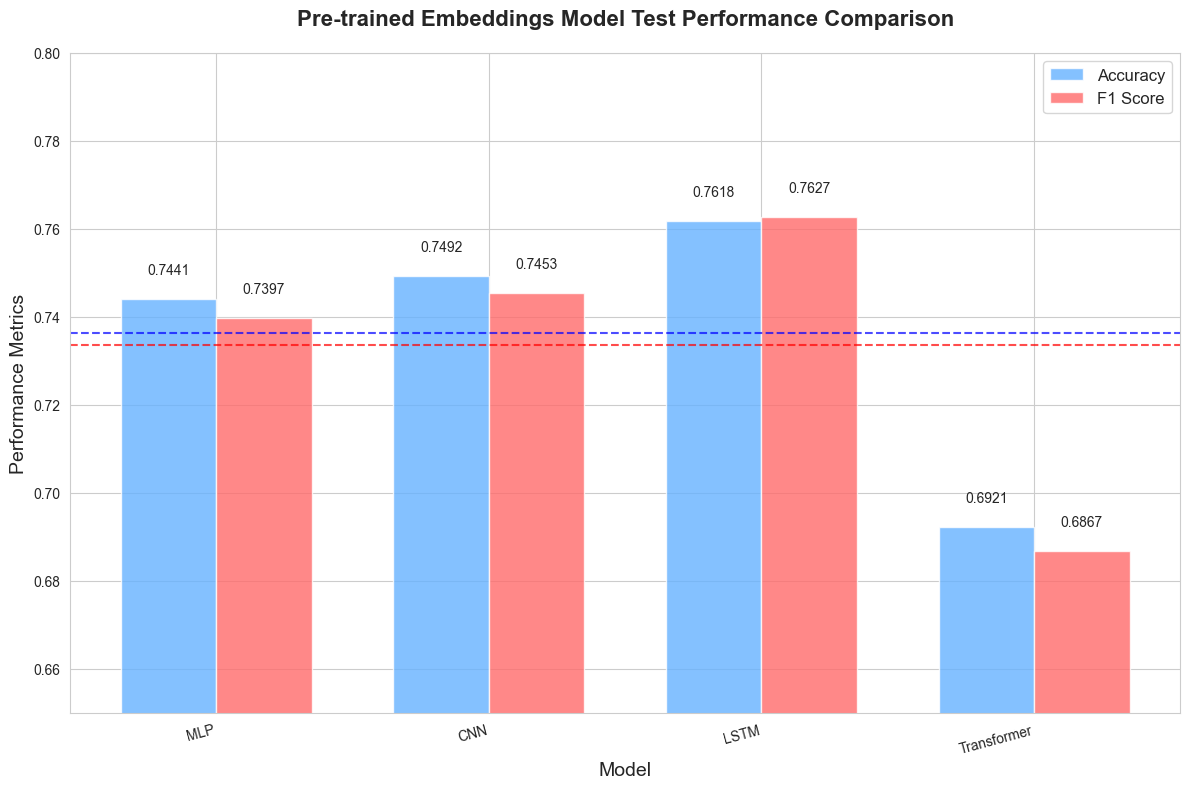

In [9]:
# 3.1 提取使用预训练词向量的模型数据
def extract_pretrained_models(results):
    """提取使用预训练词向量的模型数据"""
    pretrained_models = []
    for record in results:
        if record.get('use_pretrained_embeddings', False) and record['model_class'] != 'BERT':
            pretrained_models.append(record)
    return pretrained_models

pretrained_results = extract_pretrained_models(results)
print(f"使用预训练词向量的模型数量: {len(pretrained_results)}")

# 创建预训练模型的DataFrame
pretrained_data = []
for record in pretrained_results:
    data = {
        'Model_Name': record.get('model_name', 'Unknown'),
        'Model_Class': record.get('model_class', 'Unknown'),
        'Test_Accuracy': record.get('test_results', {}).get('accuracy', 0),
        'Test_F1': record.get('test_results', {}).get('f1', 0),
        'Test_Precision': record.get('test_results', {}).get('precision', 0),
        'Test_Recall': record.get('test_results', {}).get('recall', 0),
        'Training_History': record.get('training_history', {})
    }
    pretrained_data.append(data)

pretrained_df = pd.DataFrame(pretrained_data)
print("\n使用预训练词向量模型测试性能:")
print(pretrained_df[['Model_Name', 'Test_Accuracy', 'Test_F1']].round(4))

# 3.2 预训练词向量模型测试性能比较（以TF-IDF+LR为基线）
def plot_pretrained_performance(pretrained_df, baseline_tfidf_acc, baseline_tfidf_f1):
    """绘制预训练词向量模型测试性能对比"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # 数据准备
    models = pretrained_df['Model_Name'].values
    accuracies = pretrained_df['Test_Accuracy'].values
    f1_scores = pretrained_df['Test_F1'].values
    
    x = np.arange(len(models))
    width = 0.35
    
    # 绘制柱状图
    bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#66B2FF', alpha=0.8)
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='#FF6B6B', alpha=0.8)
    
    # 添加数值标签
    for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
        ax.text(i - width/2, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)
        ax.text(i + width/2, f1 + 0.005, f'{f1:.4f}', ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel('Model', fontsize=14)
    ax.set_ylabel('Performance Metrics', fontsize=14)
    ax.set_title('Pre-trained Embeddings Model Test Performance Comparison', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([name.replace(' with Pretrained Embeddings', '') for name in models], rotation=15, ha='right')
    ax.legend(fontsize=12)
    ax.set_ylim([0.65, 0.8])
    
    # 添加基线参考线
    ax.axhline(y=baseline_tfidf_acc, color='blue', linestyle='--', alpha=0.7, 
              label=f'TF-IDF+LR Accuracy Baseline: {baseline_tfidf_acc:.4f}')
    ax.axhline(y=baseline_tfidf_f1, color='red', linestyle='--', alpha=0.7, 
              label=f'TF-IDF+LR F1 Baseline: {baseline_tfidf_f1:.4f}')
    
    plt.tight_layout()
    plt.show()
    return fig

# 获取基线性能
tfidf_acc = baseline_df[baseline_df['Model_Name'] == 'TF-IDF + LR']['Test_Accuracy'].iloc[0]
tfidf_f1 = baseline_df[baseline_df['Model_Name'] == 'TF-IDF + LR']['Test_F1'].iloc[0]

fig5 = plot_pretrained_performance(pretrained_df, tfidf_acc, tfidf_f1)

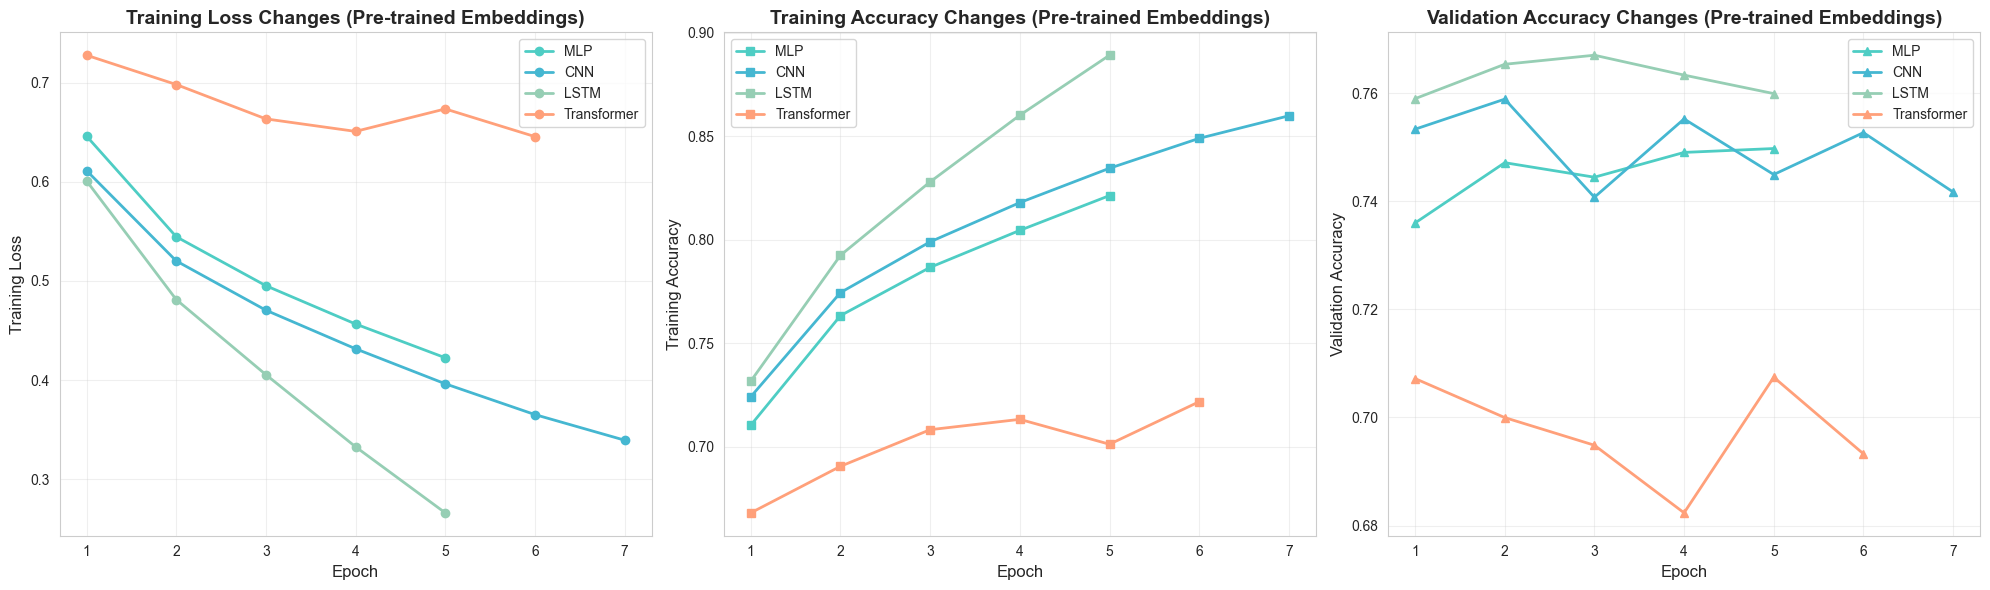

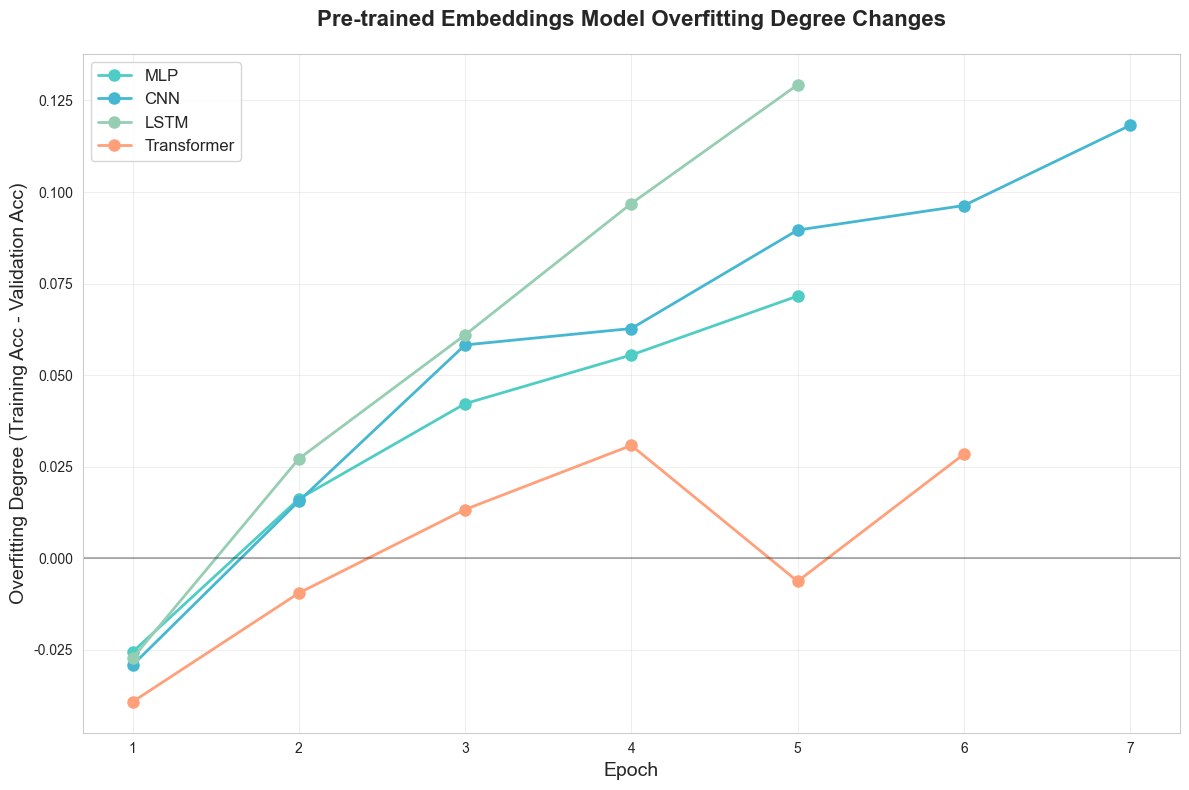

In [10]:
# 3.3 预训练词向量模型训练过程比较
def plot_pretrained_training_process(pretrained_results):
    """绘制预训练词向量模型训练过程对比"""
    
    # 创建3个子图：训练损失、训练准确率、验证准确率
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    colors = ['#4ECDC4', '#45B7D1', '#96CEB4', '#FFA07A']
    
    for i, record in enumerate(pretrained_results):
        model_name = record['model_name'].replace(' with Pretrained Embeddings', '')
        history = record['training_history']
        
        epochs = list(range(1, len(history['train_losses']) + 1))
        
        # 训练损失
        ax1.plot(epochs, history['train_losses'], marker='o', 
                label=model_name, color=colors[i], linewidth=2, markersize=6)
        
        # 训练准确率
        ax2.plot(epochs, history['train_accuracies'], marker='s', 
                label=model_name, color=colors[i], linewidth=2, markersize=6)
        
        # 验证准确率
        ax3.plot(epochs, history['val_accuracies'], marker='^', 
                label=model_name, color=colors[i], linewidth=2, markersize=6)
    
    # 设置子图1：训练损失
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title('Training Loss Changes (Pre-trained Embeddings)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 设置子图2：训练准确率
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Training Accuracy', fontsize=12)
    ax2.set_title('Training Accuracy Changes (Pre-trained Embeddings)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 设置子图3：验证准确率
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Validation Accuracy', fontsize=12)
    ax3.set_title('Validation Accuracy Changes (Pre-trained Embeddings)', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return fig

# 3.4 预训练词向量模型过拟合程度比较
def plot_pretrained_overfitting(pretrained_results):
    """绘制预训练词向量模型过拟合程度分析"""
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    colors = ['#4ECDC4', '#45B7D1', '#96CEB4', '#FFA07A']
    
    for i, record in enumerate(pretrained_results):
        model_name = record['model_name'].replace(' with Pretrained Embeddings', '')
        history = record['training_history']
        
        # 计算过拟合程度
        train_acc = np.array(history['train_accuracies'])
        val_acc = np.array(history['val_accuracies'])
        overfitting = train_acc - val_acc
        
        epochs = list(range(1, len(overfitting) + 1))
        
        ax.plot(epochs, overfitting, marker='o', label=model_name, 
               color=colors[i], linewidth=2, markersize=8)
    
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Overfitting Degree (Training Acc - Validation Acc)', fontsize=14)
    ax.set_title('Pre-trained Embeddings Model Overfitting Degree Changes', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    return fig

fig6 = plot_pretrained_training_process(pretrained_results)
fig7 = plot_pretrained_overfitting(pretrained_results)

## 分析结论3：预训练词向量模型比较

### 3.1 测试性能比较（以TF-IDF+LR为基线）:
- **LSTM**：表现最佳，准确率76.18%，F1分数76.27%，相比基线提升2.5%
- **CNN**：准确率74.92%，F1分数74.53%，相比基线提升1.3%  
- **MLP**：准确率74.41%，F1分数73.97%，相比基线提升0.6%
- **Transformer**：表现最差，准确率69.21%，F1分数68.67%，相比基线下降4.4%

### 3.2 训练过程分析:
- **收敛速度**：LSTM和MLP最快（5个epoch），Transformer次之（6个epoch），CNN最慢（7个epoch）
- **训练稳定性**：LSTM训练最稳定，损失平滑下降；CNN和MLP表现稳定；Transformer仍然波动较大
- **验证性能**：LSTM验证准确率最高且持续提升；CNN稳步改善；MLP和Transformer表现中等

### 3.3 过拟合分析:
- **LSTM**：过拟合最严重，随训练进行过拟合程度持续增加，最终达到13%
- **CNN**：中等过拟合，训练后期过拟合程度约为12%
- **MLP**：轻度过拟合，过拟合程度约为7%
- **Transformer**：过拟合程度最轻，约为3%，但整体性能仍然较差

**关键发现**：使用预训练词向量后，LSTM仍然是最佳选择，但过拟合问题依然存在且更加严重；CNN有一定改善；Transformer性能依然较差，可能不适合该任务或需要更深入的调参。

# 4. 预训练词向量对模型性能的影响分析

In [11]:
# 4.1 预训练词向量对测试性能的影响
def analyze_pretrained_impact(baseline_results, pretrained_results):
    """分析预训练词向量对模型性能的影响"""
    
    # 创建对比数据
    comparison_data = []
    
    # 模型类型映射（去除预训练词向量后缀）
    model_mapping = {
        'MLP with Pretrained Embeddings': 'MLP',
        'CNN with Pretrained Embeddings': 'CNN', 
        'LSTM with Pretrained Embeddings': 'LSTM',
        'Transformer with Pretrained Embeddings': 'Transformer'
    }
    
    # 创建基线模型字典
    baseline_dict = {}
    for record in baseline_results:
        if 'TF-IDF' not in record['model_name']:  # 排除TF-IDF+LR
            baseline_dict[record['model_name']] = record
    
    # 对比分析
    for record in pretrained_results:
        pretrained_name = record['model_name']
        baseline_name = model_mapping.get(pretrained_name)
        
        if baseline_name and baseline_name in baseline_dict:
            baseline_record = baseline_dict[baseline_name]
            
            baseline_acc = baseline_record['test_results']['accuracy']
            pretrained_acc = record['test_results']['accuracy']
            
            baseline_f1 = baseline_record['test_results']['f1']
            pretrained_f1 = record['test_results']['f1']
            
            comparison_data.append({
                'Model': baseline_name,
                'Baseline_Acc': baseline_acc,
                'Pretrained_Acc': pretrained_acc,
                'Acc_Improvement': pretrained_acc - baseline_acc,
                'Acc_Improvement_Pct': ((pretrained_acc - baseline_acc) / baseline_acc) * 100,
                'Baseline_F1': baseline_f1,
                'Pretrained_F1': pretrained_f1,
                'F1_Improvement': pretrained_f1 - baseline_f1,
                'F1_Improvement_Pct': ((pretrained_f1 - baseline_f1) / baseline_f1) * 100
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("预训练词向量对模型性能的影响:")
    print("="*80)
    for _, row in comparison_df.iterrows():
        print(f"{row['Model']}:")
        print(f"  准确率: {row['Baseline_Acc']:.4f} → {row['Pretrained_Acc']:.4f} "
              f"(提升: {row['Acc_Improvement']:+.4f}, {row['Acc_Improvement_Pct']:+.2f}%)")
        print(f"  F1分数: {row['Baseline_F1']:.4f} → {row['Pretrained_F1']:.4f} "
              f"(提升: {row['F1_Improvement']:+.4f}, {row['F1_Improvement_Pct']:+.2f}%)")
        print()
    
    return comparison_df

comparison_df = analyze_pretrained_impact(baseline_results, pretrained_results)

预训练词向量对模型性能的影响:
MLP:
  准确率: 0.7436 → 0.7441 (提升: +0.0005, +0.07%)
  F1分数: 0.7398 → 0.7397 (提升: -0.0001, -0.01%)

CNN:
  准确率: 0.7278 → 0.7492 (提升: +0.0214, +2.93%)
  F1分数: 0.7199 → 0.7453 (提升: +0.0255, +3.54%)

LSTM:
  准确率: 0.7604 → 0.7618 (提升: +0.0013, +0.18%)
  F1分数: 0.7572 → 0.7627 (提升: +0.0054, +0.72%)

Transformer:
  准确率: 0.6997 → 0.6921 (提升: -0.0076, -1.08%)
  F1分数: 0.6944 → 0.6867 (提升: -0.0076, -1.10%)



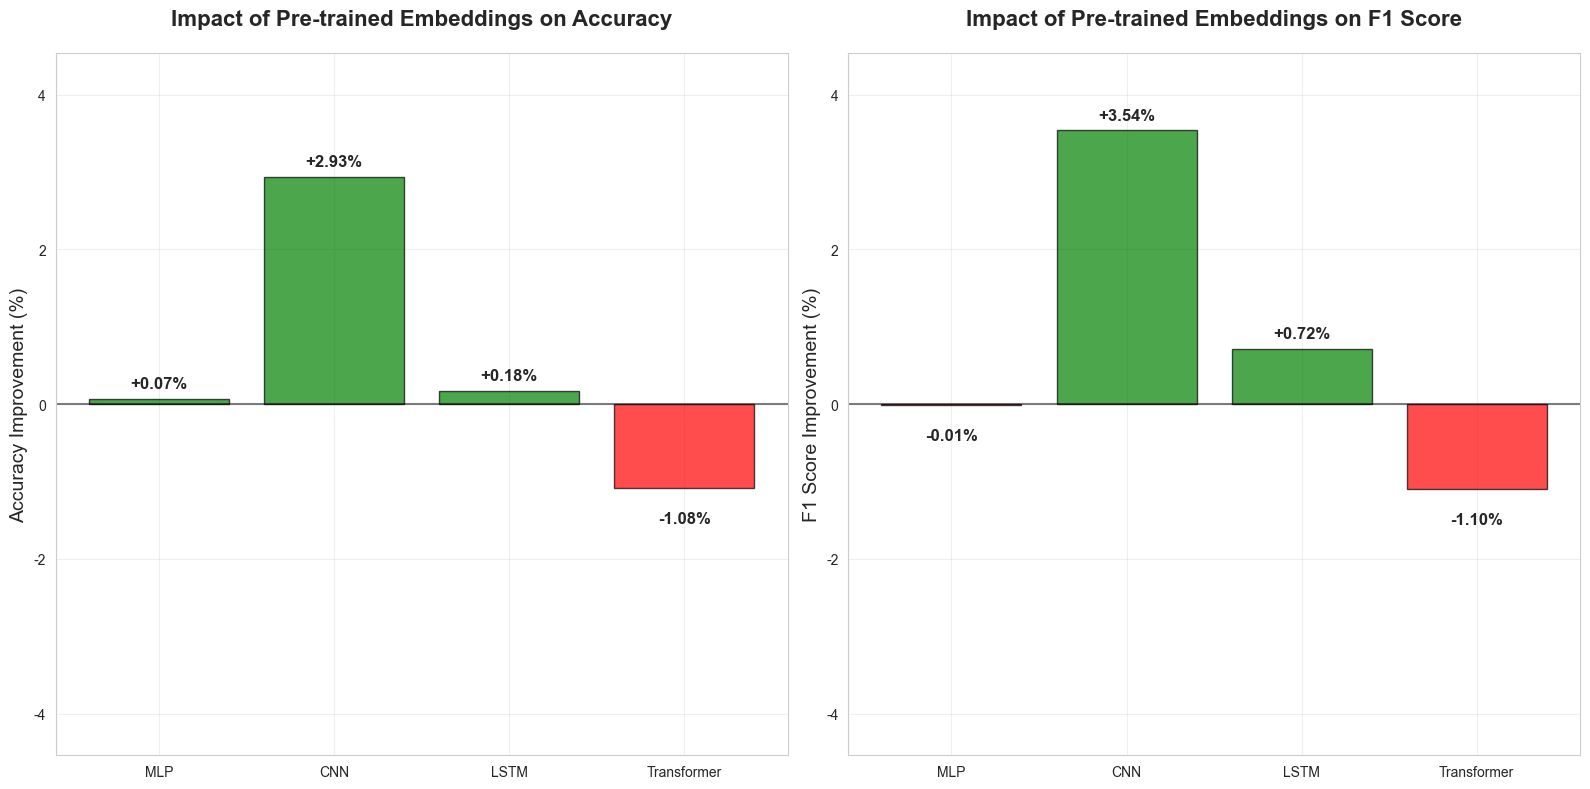

In [12]:
# 4.2 预训练词向量影响可视化
def plot_pretrained_impact(comparison_df):
    """绘制预训练词向量对模型性能的影响"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    models = comparison_df['Model'].values
    acc_improvements = comparison_df['Acc_Improvement_Pct'].values
    f1_improvements = comparison_df['F1_Improvement_Pct'].values
    
    # 设置颜色（正提升用绿色，负提升用红色）
    colors_acc = ['green' if x >= 0 else 'red' for x in acc_improvements]
    colors_f1 = ['green' if x >= 0 else 'red' for x in f1_improvements]
    
    # 准确率提升
    bars1 = ax1.bar(models, acc_improvements, color=colors_acc, alpha=0.7, edgecolor='black')
    ax1.set_title('Impact of Pre-trained Embeddings on Accuracy', fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Accuracy Improvement (%)', fontsize=14)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    
    # 添加数值标签
    for i, (bar, improvement) in enumerate(zip(bars1, acc_improvements)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., 
                height + (0.1 if height >= 0 else -0.3),
                f'{improvement:+.2f}%', ha='center', 
                va='bottom' if height >= 0 else 'top', fontsize=12, fontweight='bold')
    
    # F1分数提升
    bars2 = ax2.bar(models, f1_improvements, color=colors_f1, alpha=0.7, edgecolor='black')
    ax2.set_title('Impact of Pre-trained Embeddings on F1 Score', fontsize=16, fontweight='bold', pad=20)
    ax2.set_ylabel('F1 Score Improvement (%)', fontsize=14)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # 添加数值标签
    for i, (bar, improvement) in enumerate(zip(bars2, f1_improvements)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., 
                height + (0.1 if height >= 0 else -0.3),
                f'{improvement:+.2f}%', ha='center', 
                va='bottom' if height >= 0 else 'top', fontsize=12, fontweight='bold')
    
    # 设置y轴范围
    max_range = max(max(abs(acc_improvements)), max(abs(f1_improvements))) + 1
    ax1.set_ylim([-max_range, max_range])
    ax2.set_ylim([-max_range, max_range])
    
    plt.tight_layout()
    plt.show()
    return fig

fig8 = plot_pretrained_impact(comparison_df)

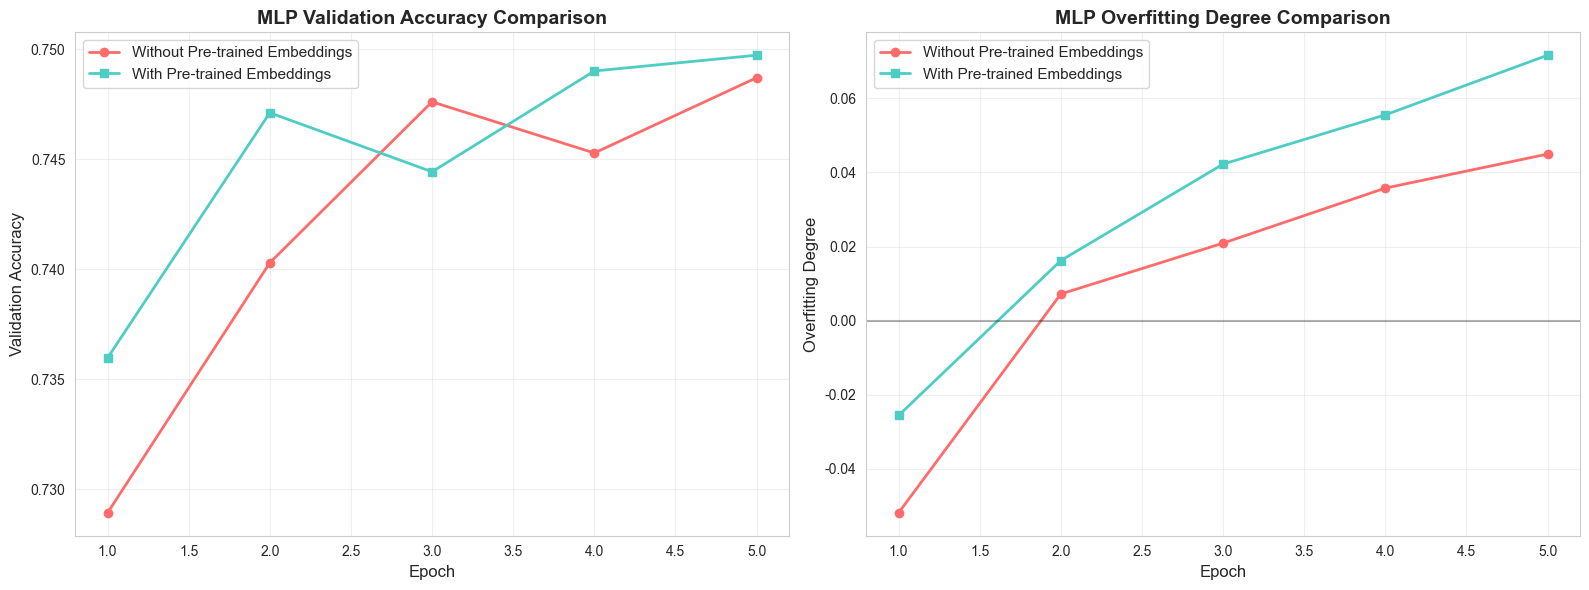

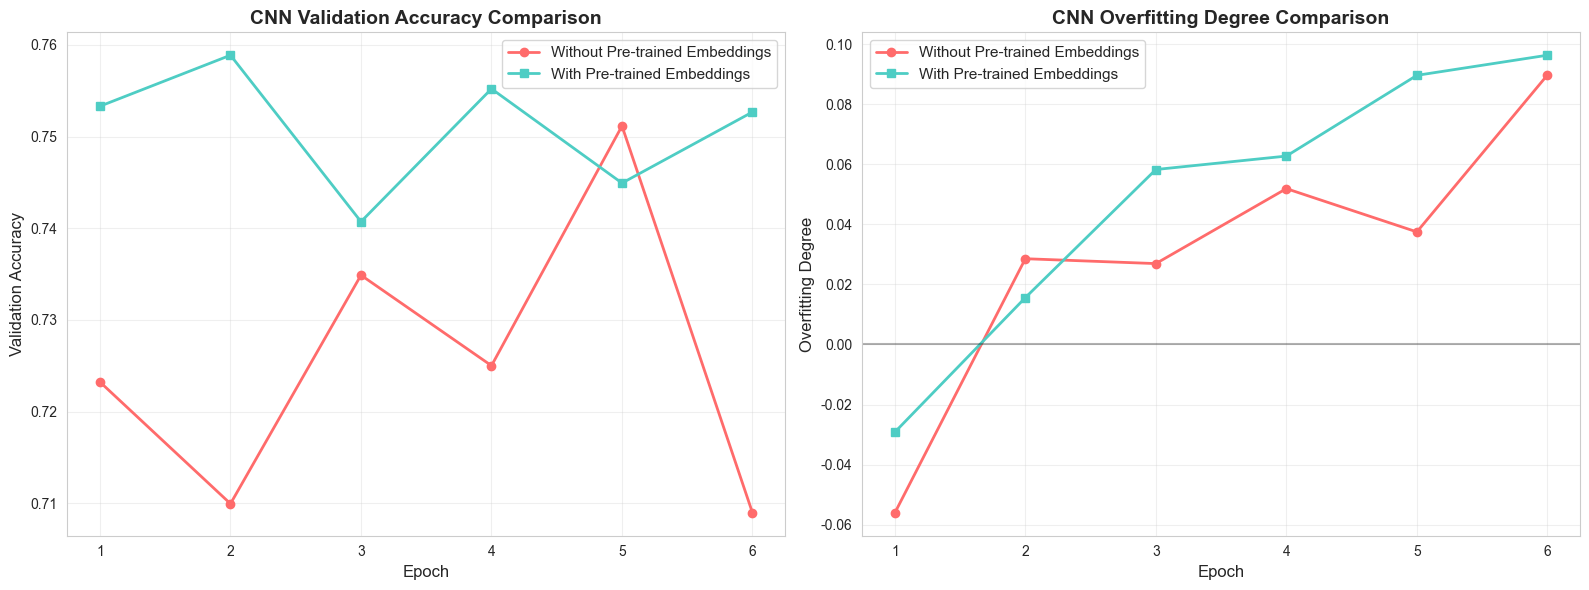

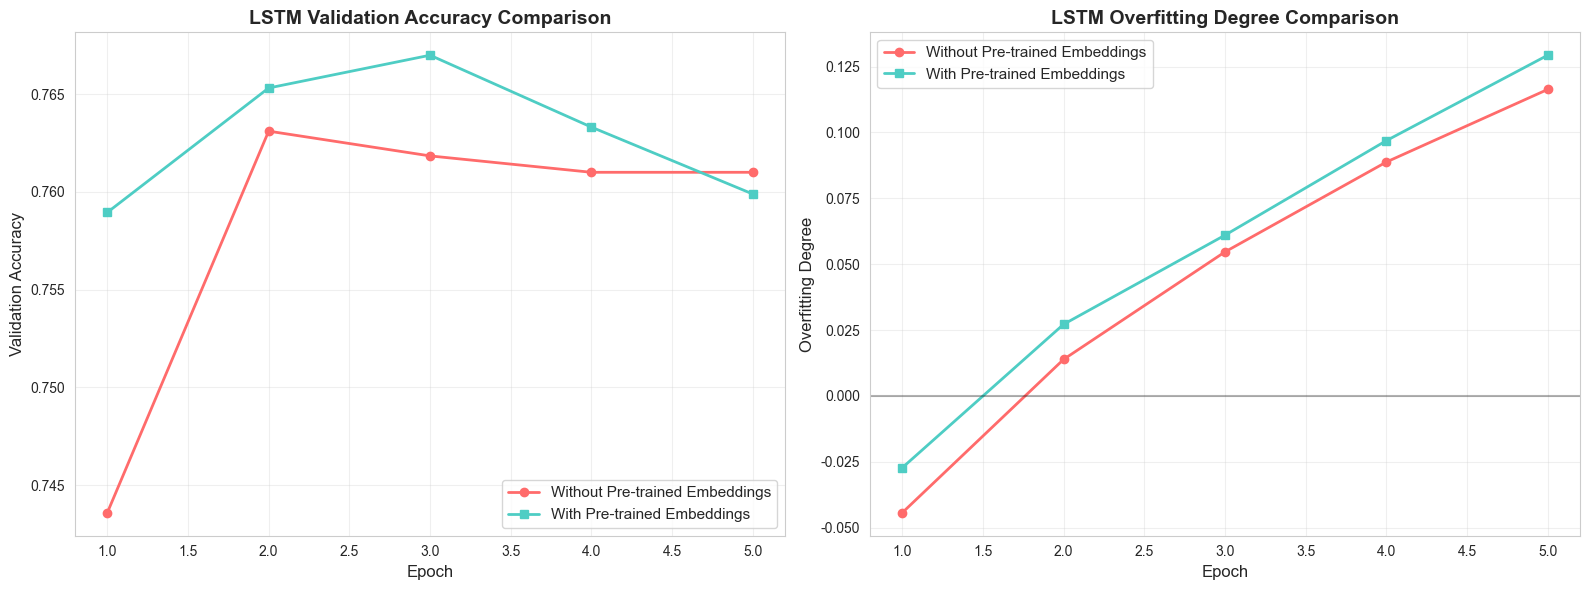

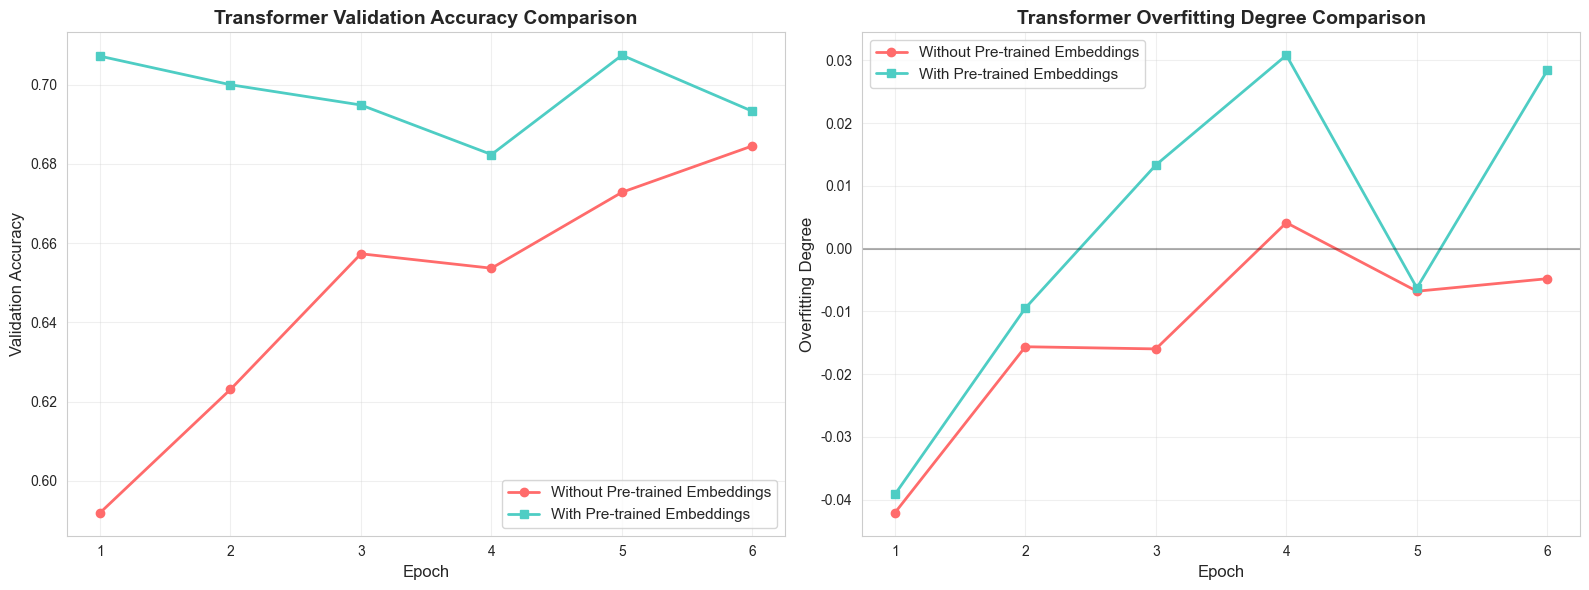

In [13]:
# 4.3 训练过程对比分析
def plot_training_comparison(baseline_results, pretrained_results):
    """对比同一模型使用预训练词向量前后的训练过程"""
    
    model_mapping = {
        'MLP with Pretrained Embeddings': 'MLP',
        'CNN with Pretrained Embeddings': 'CNN', 
        'LSTM with Pretrained Embeddings': 'LSTM',
        'Transformer with Pretrained Embeddings': 'Transformer'
    }
    
    # 创建基线模型字典
    baseline_dict = {}
    for record in baseline_results:
        if 'TF-IDF' not in record['model_name']:
            baseline_dict[record['model_name']] = record
    
    # 为每个模型创建对比图
    for record in pretrained_results:
        pretrained_name = record['model_name']
        baseline_name = model_mapping.get(pretrained_name)
        
        if baseline_name and baseline_name in baseline_dict:
            baseline_record = baseline_dict[baseline_name]
            
            # 获取训练历史
            baseline_history = baseline_record['training_history']
            pretrained_history = record['training_history']
            
            # 找到共同的epoch数（取较小值）
            common_epochs = min(len(baseline_history['val_accuracies']), 
                              len(pretrained_history['val_accuracies']))
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            epochs = list(range(1, common_epochs + 1))
            
            # 验证准确率对比
            baseline_val_acc = baseline_history['val_accuracies'][:common_epochs]
            pretrained_val_acc = pretrained_history['val_accuracies'][:common_epochs]
            
            ax1.plot(epochs, baseline_val_acc, marker='o', label='Without Pre-trained Embeddings', 
                    color='#FF6B6B', linewidth=2, markersize=6)
            ax1.plot(epochs, pretrained_val_acc, marker='s', label='With Pre-trained Embeddings', 
                    color='#4ECDC4', linewidth=2, markersize=6)
            
            ax1.set_xlabel('Epoch', fontsize=12)
            ax1.set_ylabel('Validation Accuracy', fontsize=12)
            ax1.set_title(f'{baseline_name} Validation Accuracy Comparison', fontsize=14, fontweight='bold')
            ax1.legend(fontsize=11)
            ax1.grid(True, alpha=0.3)
            
            # 过拟合程度对比
            baseline_train_acc = baseline_history['train_accuracies'][:common_epochs]
            baseline_overfitting = np.array(baseline_train_acc) - np.array(baseline_val_acc)
            
            pretrained_train_acc = pretrained_history['train_accuracies'][:common_epochs]
            pretrained_overfitting = np.array(pretrained_train_acc) - np.array(pretrained_val_acc)
            
            ax2.plot(epochs, baseline_overfitting, marker='o', label='Without Pre-trained Embeddings', 
                    color='#FF6B6B', linewidth=2, markersize=6)
            ax2.plot(epochs, pretrained_overfitting, marker='s', label='With Pre-trained Embeddings', 
                    color='#4ECDC4', linewidth=2, markersize=6)
            
            ax2.set_xlabel('Epoch', fontsize=12)
            ax2.set_ylabel('Overfitting Degree', fontsize=12)
            ax2.set_title(f'{baseline_name} Overfitting Degree Comparison', fontsize=14, fontweight='bold')
            ax2.legend(fontsize=11)
            ax2.grid(True, alpha=0.3)
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            
            plt.tight_layout()
            plt.show()

# 绘制所有模型的训练过程对比
plot_training_comparison(baseline_results, pretrained_results)

## 分析结论4：预训练词向量对模型性能的影响

### 4.1 测试性能影响：

**显著提升的模型：**
- **CNN**: 准确率提升2.93%，F1分数提升3.54%，是受益最大的模型
- **LSTM**: 轻微提升，准确率提升0.18%，F1分数提升0.72%

**无显著影响的模型：**
- **MLP**: 几乎无变化，准确率提升0.07%，F1分数下降0.01%

**负面影响的模型：**
- **Transformer**: 性能下降，准确率下降1.08%，F1分数下降1.10%

### 4.2 训练过程影响：

**验证准确率变化：**
- **MLP**: 使用预训练词向量后验证准确率略有提升，趋势更稳定
- **CNN**: 明显改善，验证准确率提升且波动减小
- **LSTM**: 验证准确率略有提升，但在训练后期有所回落
- **Transformer**: 预训练词向量使验证准确率变化模式发生改变，但整体水平仍较低

**过拟合程度变化：**
- **MLP**: 使用预训练词向量后过拟合程度增加
- **CNN**: 过拟合程度相对稳定，但绝对值有所增加
- **LSTM**: 过拟合问题加剧，两种情况下都呈现严重过拟合
- **Transformer**: 过拟合程度变化不规律，但整体较轻

### 4.3 关键发现：

1. **CNN是预训练词向量的最大受益者**，性能提升最显著
2. **LSTM虽然性能最好，但过拟合问题严重**，无论是否使用预训练词向量
3. **MLP对预训练词向量不敏感**，可能因其结构简单，无法充分利用预训练信息
4. **Transformer在该任务上表现不佳**，预训练词向量反而造成负面影响，可能需要更多数据或不同的预训练策略
5. **预训练词向量总体上对模型有正面影响**，但效果因模型架构而异

# 5. 总体结论与建议

## 5.1 实验结果总结

通过对10个模型（基线模型、深度学习模型、预训练词向量增强模型、预训练语言模型）的全面比较分析，我们得出以下主要结论：

### 最佳模型选择：
1. **MacBERT** 是本次实验的最佳模型，准确率82.66%，F1分数82.43%
2. **LSTM (with Pretrained Embeddings)** 是深度学习模型中的最佳选择，准确率76.18%，F1分数76.27%
3. **TF-IDF + LR** 作为基线模型表现稳定，为深度学习模型提供了合理基准

### 模型性能层次：
- **第一梯队**: MacBERT (82.66%)
- **第二梯队**: LSTM系列 (76.04%-76.18%)
- **第三梯队**: CNN、MLP系列 (72.78%-74.92%)  
- **第四梯队**: Transformer系列 (69.21%-69.97%)

### 预训练词向量影响：
- **CNN受益最显著** (准确率+2.93%, F1+3.54%)
- **LSTM轻微提升** (准确率+0.18%, F1+0.72%)
- **MLP基本无影响** (准确率+0.07%, F1-0.01%)
- **Transformer出现负面影响** (准确率-1.08%, F1-1.10%)

## 5.2 实际应用建议

### 如果追求最佳性能：
推荐使用 **MacBERT**，虽然模型较大、计算成本高，但性能显著优于其他所有模型。

### 如果平衡性能与效率：
推荐使用 **LSTM + 预训练词向量**，在深度学习模型中性能最佳，训练相对稳定。

### 如果资源受限：
推荐使用 **TF-IDF + Logistic Regression**，模型简单、训练快速，性能达到可接受水平。

### 如果需要进一步优化：
1. 对LSTM模型采用更强的正则化策略以减少过拟合
2. 对Transformer模型尝试更大的数据集或不同的预训练策略
3. 考虑集成学习方法，组合多个模型的预测结果

## 5.3 技术洞察

1. **预训练语言模型**（MacBERT）在中文文本情感分析任务上具有显著优势
2. **序列建模能力**对情感分析任务至关重要，LSTM优于CNN和MLP
3. **预训练词向量**对不同架构的影响差异很大，需要针对性选择
4. **Transformer**在该数据集上表现不佳，可能需要更多调优或更大数据集
5. **过拟合**是深度学习模型面临的主要挑战，尤其是LSTM模型

这次实验为基于机器学习的微博文本情感分类提供了全面的模型对比和实用指导。